In [1]:
%matplotlib widget

In [2]:
%cd ..

d:\Users\NitroPC\Documents\Python\ConcursoModelizacion2023


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from gradient_descent import Environment, Agent, ConstrainedLoss_v2, CostLoss, DistanceLoss, optimize
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from utils import plot_location

In [4]:
dt = 1.
g = 0.1
m = 10.
F_max = 11.
p_0 = np.array([50., 50., 100.])
v_0 = np.array([-10., 0., -10.])
alpha = 0.5
gamma = 1.

In [5]:
def check_factibility(K):
    agent = Agent(K)
    env = Environment(dt, gamma, g, m, p_0, v_0)

    loss = ConstrainedLoss_v2(dt, gamma, F_max, alpha)
    optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.993)

    optimize(env, agent, loss, optim, scheduler, iters=2000, verbose=True)

    d_loss = DistanceLoss()

    f = agent()
    p, v = env(f)
    d1, d2 = d_loss(f, p, v)
    d1, d2 = d1.item(), d2.item()

    factible = False
    if d1<1. and d2<1.:
        factible = True

    print(K, d1, d2, factible)

    return factible

In [6]:
#b_factible = True
#K = 19

#while b_factible:
#    b_factible = check_factibility(K)
#    K -= 1


In [7]:
def optimize(env, agent, loss, loss2, optim, scheduler=None, iters=10000, verbose=True):
    losses_1, losses_2 = [], []
    params = []
    
    for i in range(iters):
        f = agent()
        p, v = env(f)
        l = loss(f, p, v)

        optim.zero_grad()
        l.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(agent.parameters(), 10.)
        optim.step()

        if scheduler is not None:
            scheduler.step()

        if verbose and i%10==0:
            l1 = l.item()
            losses_1 += [l1]
            losses_2 += [loss2(f, p, v).item()]
            params += [f.detach().clone().numpy()]

            print(l1, scheduler.get_last_lr())
            
    return losses_1, losses_2, params

In [8]:
K=20
agent = Agent(K)
env = Environment(dt, gamma, g, m, p_0, v_0)

loss = ConstrainedLoss_v2(dt, gamma, F_max, alpha)
loss = CostLoss(dt, gamma)
optim = torch.optim.RMSprop(agent.parameters(), lr=1e-0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.995)

losses_1, losses_2, params = optimize(env, agent, loss, loss2, optim, scheduler, iters=2000, verbose=True)

AttributeError: 'ExponentialLR' object has no attribute 'zero_grad'

In [ ]:
f = agent()
p, v = env(f)

In [ ]:
d_loss = DistanceLoss()
c_loss = CostLoss(dt, gamma)

In [ ]:
print(loss(f, p, v))
print(d_loss(f, p, v))
print(c_loss(f, p, v))

tensor(0.0109, grad_fn=<AddBackward0>)
(tensor(0.0011, grad_fn=<LinalgVectorNormBackward0>), tensor(0.0002, grad_fn=<LinalgVectorNormBackward0>))
tensor(205.4818, grad_fn=<MulBackward0>)


In [ ]:
f = agent()
p, v = env(f)

d1, d2 = d_loss(f, p, v)
d1, d2 = d1.item(), d2.item()

factible = False
if d1<1. and d2<1.:
    factible = True

print(K, d1, d2, factible)

20 0.0010910461423918605 0.00018803421698976308 True


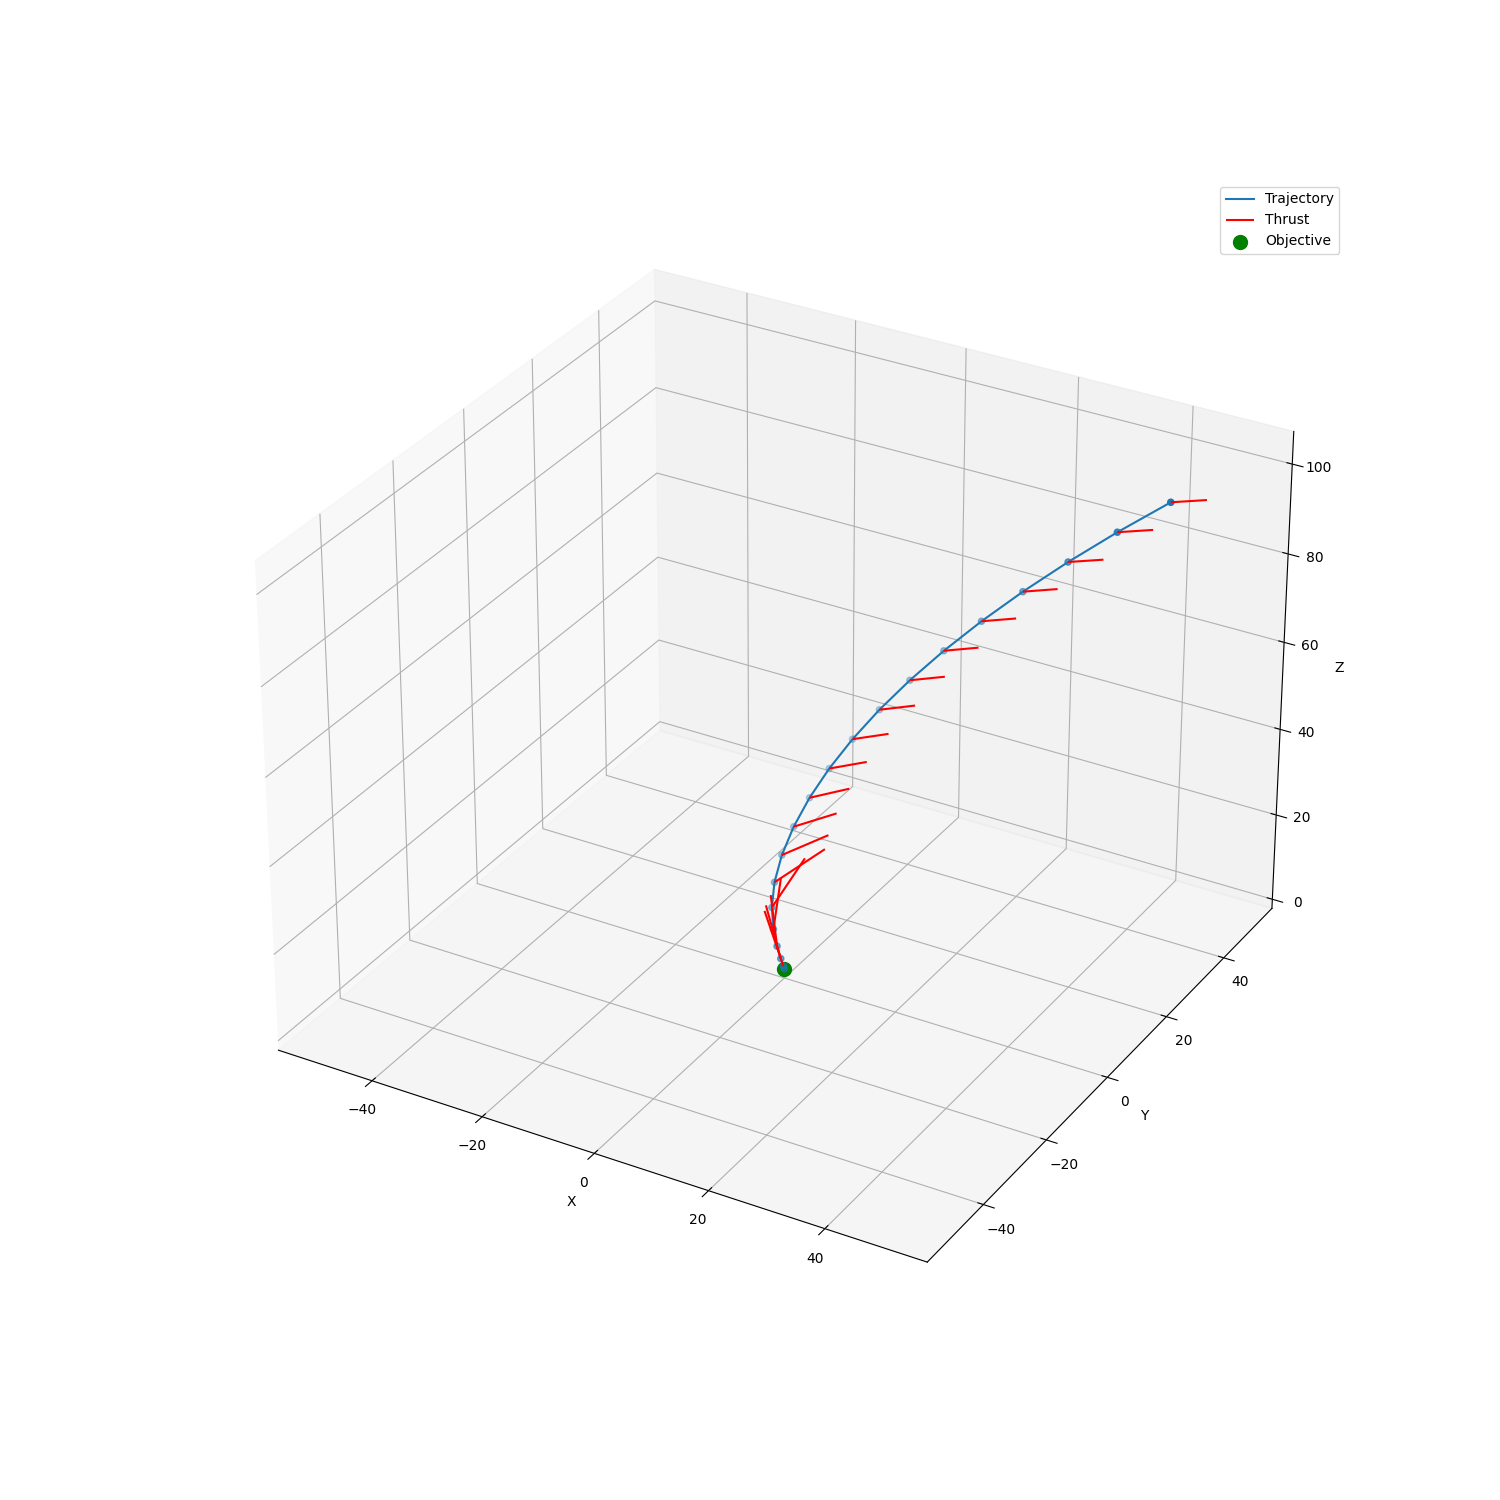

In [ ]:
plot_location(f, p, v, lambd=1.0)

NameError: name 'losses_1' is not defined

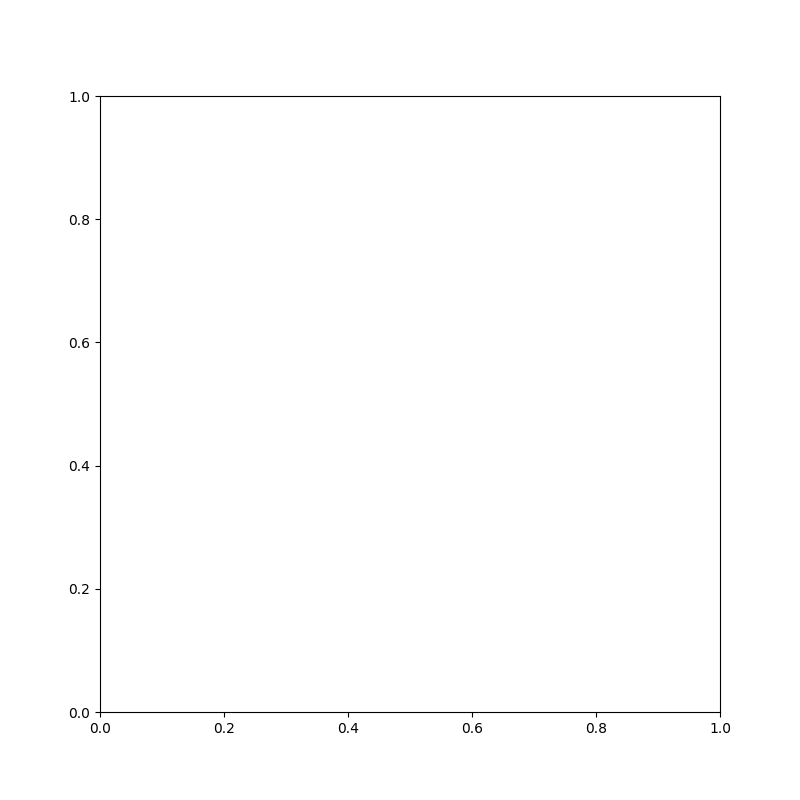

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(0,1000,10), losses_1, label='Surrogate Loss')
ax.plot(np.arange(0,1000,10), losses_2, label='Cost')
#ax.set_title('Loss')
ax.set_yscale('log')

ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
ax.legend()
plt.savefig("images/loss_v5.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

num = 100
colors = plt.cm.Blues(np.linspace(0,1,num))

for i in range(num):
    axs[0].plot(params_np[i,:,0], color=colors[i])
    axs[1].plot(params_np[i,:,1], color=colors[i])
    axs[2].plot(params_np[i,:,2], color=colors[i])
axs[0].set_title('X')
axs[1].set_title('Y')
axs[2].set_title('Z')

axs[0].set_ylim(-10, 10)
axs[1].set_ylim(-10, 10)
axs[2].set_ylim(-10, 10)

axs[0].set_xlim(0,35)
axs[1].set_xlim(0,35)
axs[2].set_xlim(0,35)

axs[2].xaxis.set_ticks(np.arange(0,40,5))

norm = mpl.colors.Normalize(vmin=0, vmax=1000)
  
# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)
sm.set_array([])
  
plt.colorbar(sm, ticks=np.linspace(0, 1000, 11))


plt.savefig("images/fuerza_v4.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
lambd = 1.
if isinstance(p, torch.Tensor) and isinstance(v, torch.Tensor):
    p = p.detach().numpy()
    v = v.detach().numpy()
    f = f.detach().numpy()

ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')
ax.plot(p[:,0], p[:,1], p[:,2], zdir='z', label='Trajectory')
ax.scatter(p[:,0], p[:,1], p[:,2], zdir='z')

p2 = p + lambd*f
p_combine = np.stack([p, p2]).transpose((1, 0, 2))
lines = Line3DCollection(p_combine, color='r', label='Thrust')
ax.add_collection(lines)


ax.scatter(0,0,0, zdir='z', c='g', s=100, label='Objective')
ax.legend()
ax.set_xlim(-55, 55)
ax.set_ylim(-55, 55)
ax.set_zlim(0, 105)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(azim=45, elev=15)

plt.savefig("images/optimal_v3.pdf", format="pdf", bbox_inches="tight")
plt.show()